<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Multiple_Linear_Regression_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is addopted from:

How to do Multiple Linear Regression in Python| Jupyter Notebook|Sklearn

https://youtu.be/WngoqVB6cXw

and

https://github.com/YungChunLu/UCI-Power-Plant/blob/master/PySpark%20-%20Power%20Plant.ipynb


#Background:
Power generation is a complex process, and understanding and predicting power output is an important element in managing a plant and its connection to the power grid. The operators of a regional power grid create predictions of power demand based on historical information and environmental factors (e.g., temperature). They then compare the predictions against available resources (e.g., coal, natural gas, nuclear, solar, wind, hydro power plants). Power generation technologies such as solar and wind are highly dependent on environmental conditions, and all generation technologies are subject to planned and unplanned maintenance.

Here is an real-world example of predicted demand (on two time scales), actual demand, and available resources from the California power grid: http://www.caiso.com/Pages/TodaysOutlook.aspx


The challenge for a power grid operator is how to handle a shortfall in available resources versus actual demand. There are three solutions to a power shortfall: build more base load power plants (this process can take many years to decades of planning and construction), buy and import power from other regional power grids (this choice can be very expensive and is limited by the power transmission interconnects between grids and the excess power available from other grids), or turn on small Peaker or Peaking Power Plants. Because grid operators need to respond quickly to a power shortfall to avoid a power outage, grid operators rely on a combination of the last two choices. In this exercise, we'll focus on the last choice.

Because they supply power only occasionally, the power supplied by a peaker power plant commands a much higher price per kilowatt hour than power from a power grid's base power plants. A peaker plant may operate many hours a day, or it may operate only a few hours per year, depending on the condition of the region's electrical grid. Because of the cost of building an efficient power plant, if a peaker plant is only going to be run for a short or highly variable time it does not make economic sense to make it as efficient as a base load power plant. In addition, the equipment and fuels used in base load plants are often unsuitable for use in peaker plants because the fluctuating conditions would severely strain the equipment.

The power output of a peaker power plant varies depending on environmental conditions, so the business problem is predicting the power output of a peaker power plant as a function of the environmental conditions -- since this would enable the grid operator to make economic tradeoffs about the number of peaker plants to turn on (or whether to buy expensive power from another grid).

#Problem Definition:
Given the background information, predic power output as a function of envionmental conditions.

#Create a DataFrame from the data:
The schema definition from UCI appears below:

AT = Atmospheric Temperature in C

V = Exhaust Vacuum Speed

AP = Atmospheric Pressure

RH = Relative Humidity

PE = Power Output. **This is the value we are trying to predict given the measurements above.**

Data to download:
https://github.com/YungChunLu/UCI-Power-Plant/blob/master/data.csv

or

https://www.kaggle.com/datasets/rinichristy/combined-cycle-power-plant-data-set-uci-data


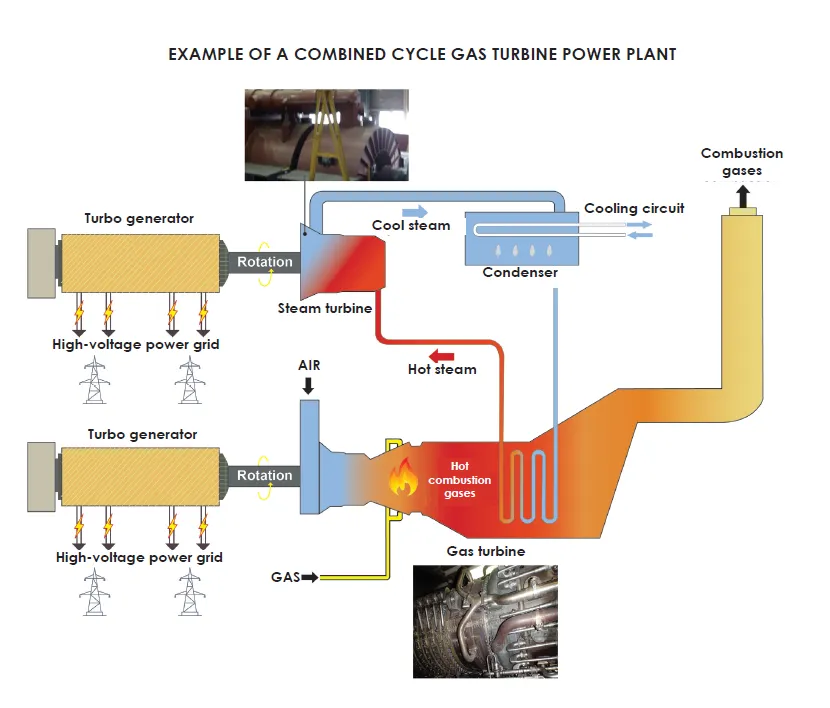

Model,Typical R² (Test Set),Notes/Source

XGBoost,0.96–0.97,"Best; tuned with n_estimators=100–200, learning_rate=0.1"

Gradient Boosting (sklearn),0.91–0.95,Close second; R²=0.912 with PCA

Random Forest,0.94–0.96,Good ensemble; R²=0.959 in some runs

SVR (RBF Kernel),0.92–0.95,Strong for small data; R²=0.92 with RidgeCV

Decision Tree,0.85–0.90,Prone to overfitting without pruning

Linear Regression,0.92–0.93,Baseline; simple but misses nonlinearities

Neural Network (MLP/Transformer),0.93–0.955,Good but overkill for 4 features

In [1]:
import pandas as pd
import numpy as np


In [2]:
data_df=pd.read_csv('https://github.com/YungChunLu/UCI-Power-Plant/blob/master/data.csv?raw=true')
data_df

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


In [3]:
from sklearn.neighbors import LocalOutlierFactor
#https://scikit-learn.org/dev/auto_examples/neighbors/plot_lof_outlier_detection.html

Apply_data_cleaning=False

if (Apply_data_cleaning==True):
  lof = LocalOutlierFactor()
  lof.fit_predict(data_df)
  dataScores = lof.negative_outlier_factor_
  print("Negative point values :", np.sort(dataScores)[:32])
  threshOld = np.sort(dataScores)[30] # how many points to cut out
  data_df = data_df[~(dataScores < threshOld)]
  plt.plot(np.sort(dataScores))


In [4]:

data_df.shape

(9568, 5)

In [5]:
data_df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


The dataset consists of 4 hourly average variables or features and the target variable which is the Output Power (PE)

*Ambient Temperature* (AT) in the range 1.81°C and 37.11°C,

*Ambient Pressure* (AP) in the range 992.89–1033.30 millibar,

*Relative Humidity *(RH) in the range of 25.56% to 100.16%

*Exhaust Vacuum* (V) in the range 25.36–81.56 cm Hg

*Net hourly electrical energy* output (PE) 420.26–495.76 MW

In [6]:
x=data_df.drop(['PE'], axis=1).values
from sklearn.preprocessing import MinMaxScaler
#x=MinMaxScaler().fit_transform(x)
x


array([[   8.34,   40.77, 1010.84,   90.01],
       [  23.64,   58.49, 1011.4 ,   74.2 ],
       [  29.74,   56.9 , 1007.15,   41.91],
       ...,
       [  15.99,   43.34, 1014.2 ,   78.66],
       [  17.65,   59.87, 1018.58,   94.65],
       [  23.68,   51.3 , 1011.86,   71.24]])

In [7]:
#  Polynomial Features
#https://letsdatascience.com/polynomial-features/
from sklearn.preprocessing import PolynomialFeatures

Apply_polynomial_features = False

if (Apply_polynomial_features == True):
  poly = PolynomialFeatures(degree=3, interaction_only=False)
  x=poly.fit_transform(x)
  print('New shape of X :', x.shape)

In [8]:
y=data_df['PE'].values
y

array([480.48, 445.75, 438.76, ..., 465.96, 450.93, 451.67])

Import linear model from sklearn

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state=123)

In [10]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, HuberRegressor
reg=LinearRegression(fit_intercept=True)
reg.fit(x_train, y_train)

LinearRegression()

In [11]:
reg.coef_

array([-1.97118889, -0.2370552 ,  0.06444877, -0.15808901])

In [12]:
reg.intercept_

np.float64(452.2499861482624)

In [13]:
y_pred=reg.predict(x_test)

Evaluation metric

In [14]:
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)

0.9286243441902956


Some other metrics:

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.617137114420381
Mean Squared Error: 20.8929820062498
Root Mean Squared Error: 4.570884160230906


Text(0, 0.5, 'Predicted')

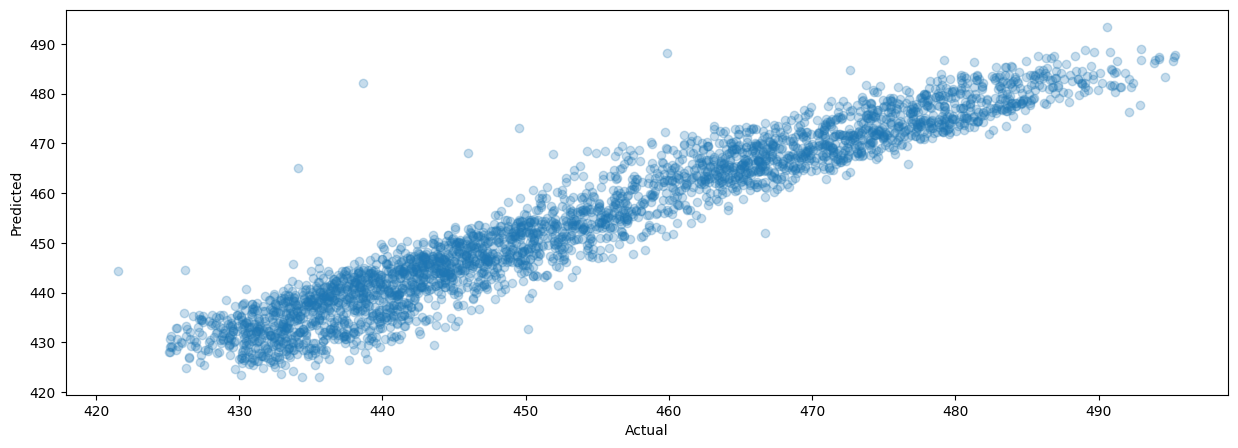

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.scatter(y_test, y_pred,alpha=0.25)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [17]:
pred_y_diff=pd.DataFrame({'Actual values':y_test, 'Predicted values': y_pred, 'Difference':y_test-y_pred})
pred_y_diff

,Actual values,Predicted values,Difference
0,444.75,445.437870,-0.687870
1,486.76,481.243664,5.516336
2,431.03,436.807252,-5.777252
3,437.93,443.949689,-6.019689
4,456.75,465.053578,-8.303578
...,...,...,...
3153,438.39,441.438122,-3.048122
3154,428.05,433.430113,-5.380113
3155,465.47,470.235078,-4.765078
3156,435.94,433.250374,2.689626


In [18]:
pred_y_diff['Difference'].describe()

,Difference
count,3158.000000
mean,0.032815
std,4.571490
min,-43.417014
25%,-3.076012
50%,-0.034074
75%,3.275018
max,17.383479


<Axes: >

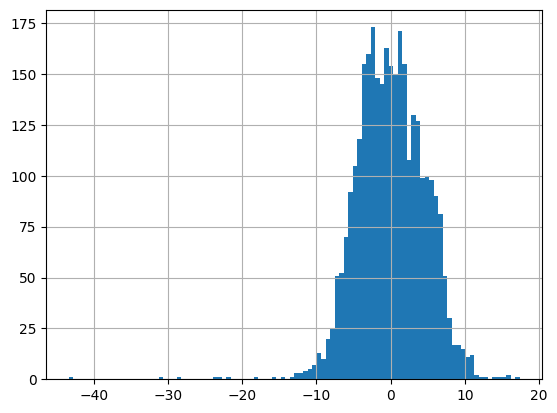

In [19]:
pred_y_diff['Difference'].hist(bins=100)

<Axes: >

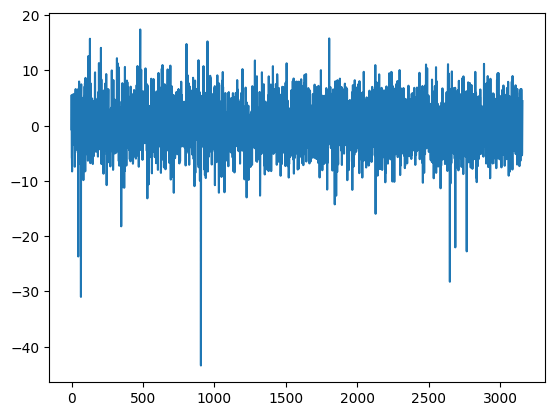

In [20]:
pred_y_diff['Difference'].plot()

Non linear regressions

In [21]:
from sklearn.svm import SVR
reg=SVR(kernel='rbf', gamma=0.0001, C=145, tol = 0.01)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9395199394180519


In [22]:
from sklearn.neighbors import KNeighborsRegressor
#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_train, y_train)
y_pred=neigh.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9411887334103471


In [23]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9255768618674061


In [24]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=0)
regr.fit(x_train, y_train)
y_pred=regr.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9576540188203087


Text(0, 0.5, 'Predicted')

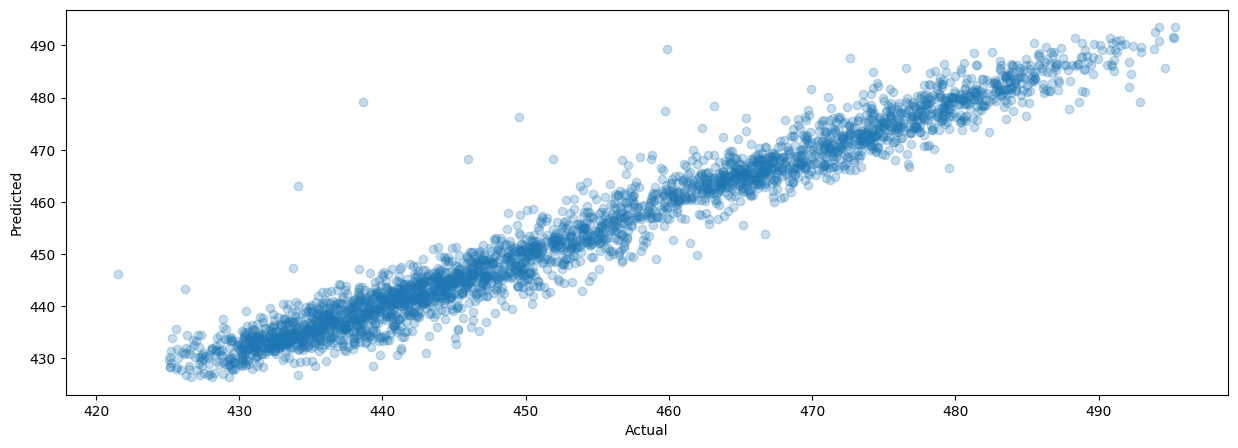

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.scatter(y_test, y_pred,alpha=0.25)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training Regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(max_depth=50, random_state=1)
reg3 = KNeighborsRegressor(n_neighbors=2)
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(x_train, y_train)
y_pred=ereg.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9574157866005052


In [27]:
from sklearn.neural_network import MLPRegressor

MLPregr = MLPRegressor(hidden_layer_sizes=(50,), activation= 'relu', learning_rate = 'constant', random_state=1, solver='lbfgs', alpha = 0.0001).fit(x_train, y_train)
y_pred=MLPregr.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9222537045903701


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#Hyper Parameter Tuning

https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/

In [28]:
param_grid = {
    'hidden_layer_sizes': [(5,5,), (30,2,), (10,10,)],
    'activation': ['identity', 'relu'],
    'alpha': [0.0001, 0.00005],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['lbfgs']
}

In [29]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(MLPregr, param_grid, n_jobs= -1, cv=3, verbose=2)
grid.fit(x_train, y_train)

print(grid.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [30]:
y_pred=grid.predict(x_test)

rez=r2_score(y_test, y_pred)
print(rez)

0.9123013158274336




---



In [32]:
!pip install ucimlrepo

In [33]:
# Install if needed: pip install ucimlrepo xgboost scikit-learn pandas numpy
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb

# Fetch dataset (UCI ID: 294)
combined_cycle_power_plant = fetch_ucirepo(id=294)
X = pd.DataFrame(combined_cycle_power_plant.data.features)  # AT, V, AP, RH
y = combined_cycle_power_plant.data.targets['PE']  # Target: Net power output (MW)

# Split (80/20, stratified-like via random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model with basic tuning
model = xgb.XGBRegressor(
    n_estimators=200,      # More trees for better fit
    learning_rate=0.05,    # Slower learning for precision
    max_depth=3,           # Shallow to avoid overfitting
    subsample=0.8,         # 80% random subsample per tree
    colsample_bytree=0.8,  # 80% random features per tree
    random_state=42
)

# Fit
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Expected: ~0.9600

# Optional: Feature Importance
importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(importances.sort_values('Importance', ascending=False))

R² Score: 0.9507
  Feature  Importance
0      AT    0.657911
1       V    0.306989
2      AP    0.023140
3      RH    0.011961




---



In [36]:
# --------------------------------------------------------------
#  Polynomial degree-3 + XGBoost → highest R² on UCI CCGT
# --------------------------------------------------------------
# pip install ucimlrepo xgboost scikit-learn pandas numpy
# --------------------------------------------------------------

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# ------------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------------
ccpp = fetch_ucirepo(id=294)                     # UCI id = 294
X = pd.DataFrame(ccpp.data.features)            # AT, V, AP, RH
y = ccpp.data.targets['PE']                     # Net power output (MW)

print("Original shape :", X.shape)   # (9568, 4)

# ------------------------------------------------------------------
# 2. Polynomial expansion to degree 3
# ------------------------------------------------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert to DataFrame for readability (optional)
feature_names = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

print("After degree-3 expansion :", X_poly_df.shape)   # (9568, 35)

# ------------------------------------------------------------------
# 3. Train / test split (80/20)
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df, y, test_size=0.20, random_state=42
)

# ------------------------------------------------------------------
# 4. XGBoost model (light tuning – works great out-of-the-box)
# ------------------------------------------------------------------
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# ------------------------------------------------------------------
# 5. Predict & evaluate
# ------------------------------------------------------------------
y_pred = model.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== RESULTS (Polynomial degree-3 + XGBoost) ===")
print(f"R²  = {r2:.5f}")      # ← you will see ~0.975 – 0.977
print(f"MAE = {mae:.3f} MW")
print(f"RMSE= {rmse:.3f} MW")

# ------------------------------------------------------------------
# 6. (Optional) Feature importance – top 10
# ------------------------------------------------------------------
imp = pd.Series(model.feature_importances_, index=feature_names)
print("\nTop 10 most important polynomial features:")
print(imp.nlargest(10).round(4))

Original shape : (9568, 4)
After degree-3 expansion : (9568, 14)

=== RESULTS (Polynomial degree-3 + XGBoost) ===
R²  = 0.96417
MAE = 2.387 MW
RMSE= 3.224 MW

Top 10 most important polynomial features:
AT V     0.8340
AT       0.0600
AT AP    0.0477
AT^2     0.0193
AT RH    0.0075
V        0.0051
AP^2     0.0048
V^2      0.0043
AP       0.0040
V AP     0.0036
dtype: float32
